# Import Libaries

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
import pickle
import os, sys
%matplotlib inline

# Display Images

In [2]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            ax.imshow(image)
            ax.set_title(imagePathName)

In [3]:
# Load calibration images.
input_images = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                             glob.glob('./camera_cal/c*.jpg')))

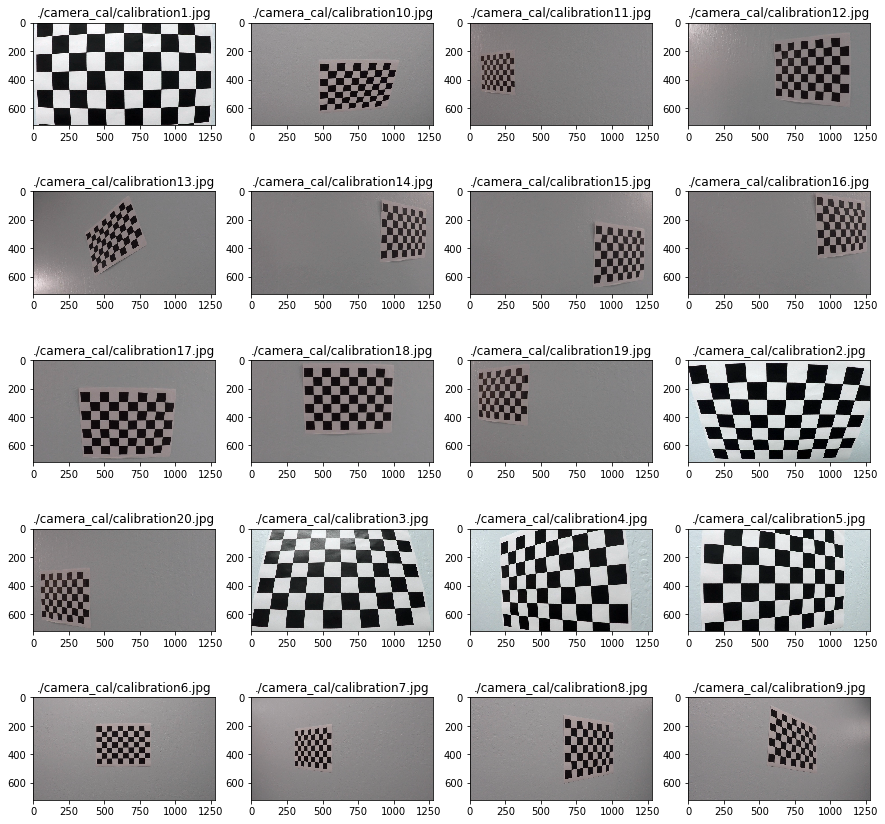

In [4]:
# Camera Calibration Input Images
showImages(input_images, 4, 5, (15, 15))

# Apply Camera Calibration

In [8]:
def get_calibration_matrix(filePath):
    """Returns camera calibration matrix using
    chessboard images in given glob path
    assuming 6x9 or 5x9 chess corners
    """
    object_points = []  # 3d point in real world space
    img_points = []  # 2d points in image plane.
    images = glob.glob(filePath)
    calibrated_images = []
    
    for filename in images:
        img = cv2.imread(filename)
        nx, ny = 6, 9
        retval, corners = cv2.findChessboardCorners(img, (nx, ny))
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)
        
        if not retval:
            nx, ny = 5, 9 # Trying with 5 rows
            objp = np.zeros((nx * ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)
            retval, corners = cv2.findChessboardCorners(img, (nx, ny))
        
        if retval:
            object_points.append(objp)
            img_points.append(corners)

            cv2.drawChessboardCorners(img, (nx, ny), corners, retval)
            calibrated_images.append((filename, img))
        else:
            print('%s: corners not found' % filename)
            calibrated_images.append((filename, img))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, img_points, img.shape[1::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs, calibrated_images

In [9]:
def get_undistorted_images(img, cameraMatrix, distCoeffs):
    """Returns undistorted image using given
    object points and image points
    """
    return cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)

In [11]:
ret, mtx, dist, rvecs, tvecs, calibrated_images = get_calibration_matrix('./camera_cal/c*.jpg')

./camera_cal/calibration4.jpg: corners not found
./camera_cal/calibration5.jpg: corners not found


In [12]:
# write out calibration data
with open('cameraCalibration.pickle', 'wb') as fp:
    pickle.dump([mtx, dist, rvecs, tvecs], fp)

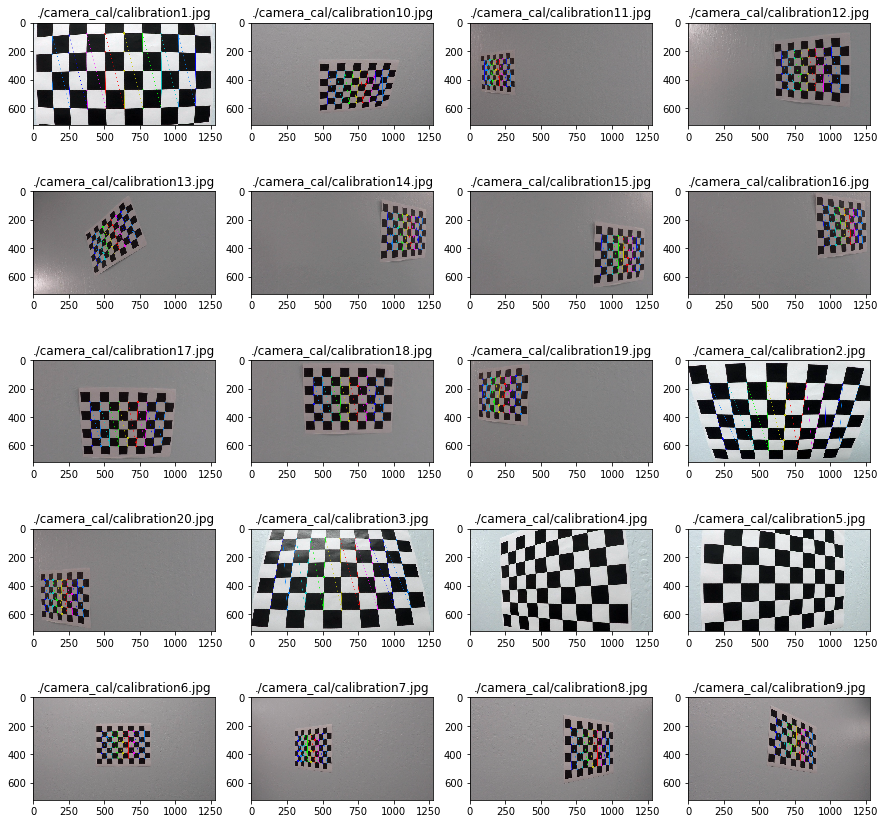

In [13]:
showImages(calibrated_images, 4, 5, (15, 15))

# Let's test an example

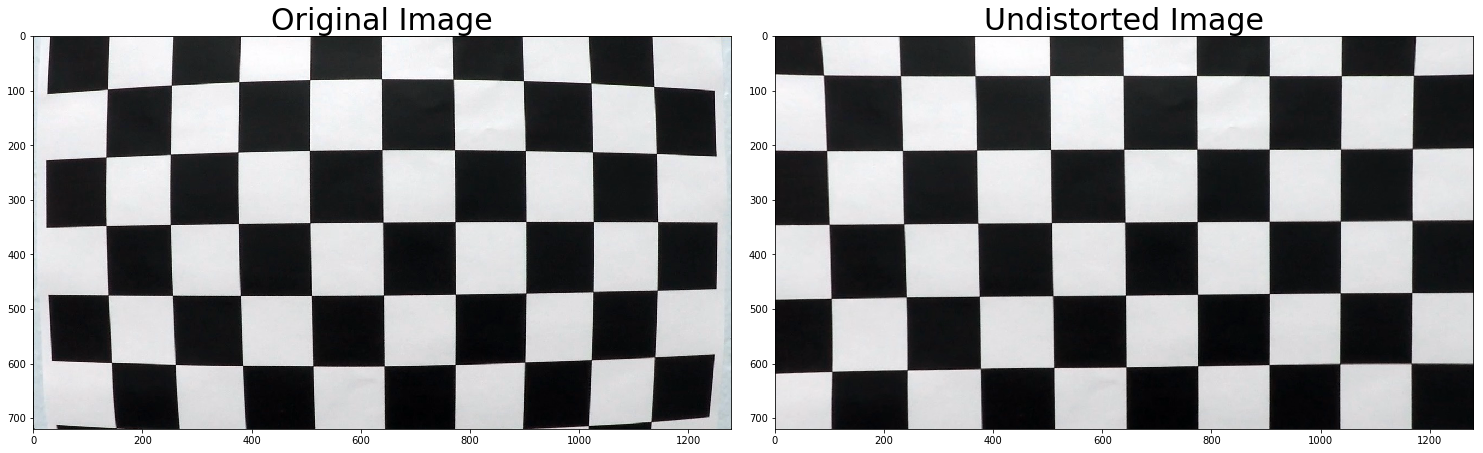

In [14]:
test_image = input_images[0][1]
undistorted_img = get_undistorted_images(test_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save all outputs

In [15]:
# write camera calibration images
outFolder = 'camera_cal_output/corner_imgs'

for image in calibrated_images:
    imagePath, img = image
    imgNumber = imagePath.split('calibration')[1].split('.jpg')[0]
    outFile = '%s/calibration_corners%s.jpg' % (outFolder, imgNumber)
    cv2.imwrite(outFile, img)

# write undistorted checkerboard images
outFolder = 'camera_cal_output/undistort_imgs/'
for image in input_images:
    imagePath, img = image
    undistorted_img = get_undistorted_images(img, mtx, dist)
    imgNumber = imagePath.split('calibration')[1].split('.jpg')[0]
    outFile = '%s/calibration_undistort%s.jpg' % (outFolder, imgNumber)
    cv2.imwrite(outFile, undistorted_img)